In [359]:
import numpy as np
import core
import pylab as plt
import nibabel as nib
import os
from skimage import filters
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import grey_dilation as gd
import time
from skimage.segmentation import find_boundaries as boundaries
import skimage
import SimpleITK as sitk
import nipype.interfaces.fsl as fsl

planes = np.load('/Users/fair00542/Desktop/DC Image Analysis/DC-project-master/cleancode/planes-params.npy')
pixelspacing = []
path = '/Users/fair00542/Desktop/DC Image Analysis/TestImages/ScanB/1.3.12.2.1107.5.1.4.51967.30000014110308064564000003663.dcm'
if path.endswith('.dcm'):
    array, ConstPixelSpacing, origin, path, affine = core.dicom2np(path)
    #bone = core.thresholdnp(array, 900, 1500)
    #softtissue  = core.thresholdnp(array, 0, 80)
    pixelspacing.append(ConstPixelSpacing)
    
#threshold, get-rid of outliars
tarray = np.multiply(array, (array>-1024).astype(int))
tarray = np.multiply(tarray, (tarray<3071).astype(int))
array1 = np.multiply(tarray, (tarray>0.0).astype(int))

#skull
skull_mask = array1>100.0 #boolea
array2 = np.multiply(array1, (array1<100.0).astype(int))

#smoothing image using Gaussian kernel, sigma =1mm3
import scipy
smoo = scipy.ndimage.filters.gaussian_filter(array2,sigma=1)
smoo = np.multiply(smoo,(smoo<100.0).astype(int))
smoo = np.multiply(smoo,(smoo>0.0).astype(int))
#array2(0,100), skull_mask>100

#orbital
orbital_mask = bc(skull_mask)
orbital_mask1 = bc(bc(bc(orbital_mask)))
array3 = np.multiply(smoo, (orbital_mask1==False).astype(int))

In [368]:
def saveMask(array, path, name):
    mask = array.astype(np.float64)
    mask = np.swapaxes(mask, 0, 1)
    img = nib.Nifti1Image(mask, affine)
    savePath = os.path.join(os.path.split(path)[0], '{}.nii.gz'.format(name))
    nib.save(img, savePath)

#bet fsl
img = nib.Nifti1Image(array3, np.eye(4))
nib.save(img, 'temp.nii.gz')
img = nib.load('temp.nii.gz')
mybet = fsl.BET()
result = mybet.run(in_file='temp.nii.gz', out_file='BET-temp.nii.gz', frac=0.2)
img = nib.load('BET-temp.nii.gz')
data = img.get_data()
array4 = data
brain_mask = np.multiply(bc(bfh(bd(array4))).astype(int), array3)

In [393]:
# Save Brain mask
path1 = '/Users/fair00542/Desktop/DC Image Analysis/TestImages/ScanB/ScanB'
bet = (brain_mask!=0).astype(int)
#saveMask(bet,path1,'bb20')
#use array before Gaussian Kernel to save brain array

#After manual segmentation in ITK-SNAP
itk = nib.load('/Users/fair00542/Desktop/DC Image Analysis/TestImages/ScanB/bb25.nii.gz')
raw1 = itk.get_data()
raw2 = np.swapaxes(raw1,0,1)
raw3 = bc(bfh(raw2))
raw4 = np.multiply(raw3,array3!=0).astype(int)

# find largest connected region
labels = skimage.measure.label(raw4, connectivity=3)
props = skimage.measure.regionprops(labels)
h = [p.area for p in props]
ind = h.index(max(h))
hcoords = props[ind].coords
h_loop = np.zeros((array.shape))
for i in range(len(hcoords)):
    a,b,c = hcoords[i]
    h_loop[a,b,c]=1

saveMask(h_loop,path1,'brain_edited')  ##edited brain mask, used to build the .stl brain shell.

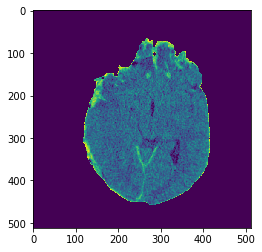

In [405]:
array5 = np.multiply(h_loop,array2).astype(int)
plt.imshow(array5[:,:,51])
plt.show()

In [406]:
array5.min()

0

# 1. ventricles

In [422]:
h_loop = brain_mask
ven_mask1 = np.multiply(brain_mask!=0, (smoo<22).astype(int))
ven_mask11 = np.multiply(brain_mask!=0, (array5<22).astype(int))
#ventricle extraction also performs better after Gaussian Kernel

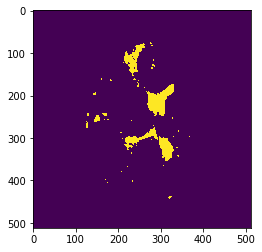

In [454]:
ven_mask2 = bd(be(bd(ven_mask1)))
plt.imshow(ven_mask2[:,:,63])
plt.show()

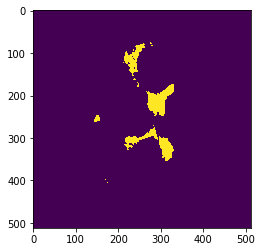

In [458]:
ven_mask3 = skimage.morphology.remove_small_objects(ven_mask2, min_size=1000, connectivity=3, in_place=False)
plt.imshow(ven_mask3[:,:,63])
plt.show()

In [459]:
labels = skimage.measure.label(ven_mask3, connectivity=3)
props = skimage.measure.regionprops(labels)
h = [p.area for p in props]
ind = h.index(max(h))
hcoords = props[ind].coords
v_loop = np.zeros((array.shape))
for i in range(len(hcoords)):
    a,b,c = hcoords[i]
    v_loop[a,b,c]=1

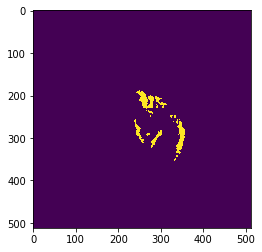

In [463]:
plt.imshow(v_loop[:,:,47])
plt.show()

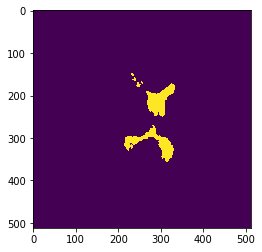

In [460]:
plt.imshow(bd(be(bd(v_loop[:,:,63]))))
plt.show()